In [397]:
import pandas as pd
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE


## Data Set Up

In [438]:
#gets the data
wine_df = pd.read_csv("./Data/wine_extracted.csv")
wine_df = wine_df[wine_df.columns[-2:].append(wine_df.columns[:-2])]

#changes the red wine to 1 and white wine to 0
wine_df.loc[wine_df["Wine"]=="Red", "Wine" ] = 1
wine_df.loc[wine_df["Wine"]=="White", "Wine" ] = 0

In [439]:
#reclassifissed the data to have 5 classes of <=5, 6, >=7
wine_df.loc[wine_df["quality"]==3, "quality"] = "<=5"
wine_df.loc[wine_df["quality"]==4, "quality"] = "<=5"
wine_df.loc[wine_df["quality"]==5, "quality"] = "<=5"

wine_df.loc[wine_df["quality"]==7,"quality"] = ">=7"
wine_df.loc[wine_df["quality"]==8,"quality"] = ">=7"
wine_df.loc[wine_df["quality"]==9,"quality"] = ">=7"

In [420]:
#prints key evalutaiton metrics
def print_metrics(true_val, pred_val):
    print("The accuracy is ",accuracy_score(true_val, pred_val))
    print(classification_report(true_val, pred_val))
    print("The confusion matrix is ")
    print(confusion_matrix(true_val, pred_val))
    

In [421]:
#prints Area under curve
def print_auc(true_val, pred_val):
    print("The AUC score is", roc_auc_score(true_val, pred_val, multi_class='ovr'))

## Train/Test split, Standardisation and SMOTE Oversampling

In [440]:
#splitting data into attributes and target
cols = wine_df.columns

X = wine_df[cols[1:]]
Y = wine_df["quality"].astype('str')

X.head()

,Wine,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,1,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,1,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [441]:
#standardisation

#standard scaler is chosen
scaler = StandardScaler()

#the scaler is fit and transforms the X and converted back to a data frame
standard_X = pd.DataFrame(data = scaler.fit_transform(X))
standard_X.columns = X.columns

#chanegs back the wine attribute as it is boolean
standard_X["Wine"] = X["Wine"]

standard_X.head()

,Wine,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464
1,1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068
2,1,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068
3,1,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068
4,1,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464


In [446]:
#data is plit into trainging and test data sets 
train_X,test_X,train_Y,test_Y =  train_test_split(standard_X, Y, test_size = 0.2, random_state = 42)

print("Train size: ",train_X.shape)
print("Test size: ",test_X.shape)

Train size:  (5197, 12)
Test size:  (1300, 12)


In [447]:

#Oversampling
sm = SMOTE(random_state=42)
train_X_smote, train_Y_smote =sm.fit_resample(train_X, train_Y)
train_Y_smote.value_counts()

<=5    2239
>=7    2239
6      2239
Name: quality, dtype: int64

## Support Vector Machine Classifier

In [237]:
#SVM is intiatied and fitted
svm_model = SVC(kernel = "poly", probability = True, random_state = 42)
svm_model = svm_model.fit(train_X_smote, train_Y_smote)

In [314]:
#predicts the 
print_metrics(test_Y, svm_model.predict(test_X))
print_auc(test_Y, svm_model.predict_proba(test_X))#warning this is very slow and might not be accurate to the actual prob_a as stated in the sklearn

The accuracy is  0.5769230769230769
              precision    recall  f1-score   support

           6       0.58      0.52      0.55       597
         <=5       0.63      0.64      0.63       451
         >=7       0.49      0.60      0.54       252

    accuracy                           0.58      1300
   macro avg       0.57      0.59      0.57      1300
weighted avg       0.58      0.58      0.58      1300

The confusion matrix is 
[[310 166 121]
 [128 290  33]
 [ 95   7 150]]
The AUC score is 0.7523022415124592


## Random Forest

In [444]:
#intiate random forest
random_forest = RandomForestClassifier(n_estimators = 100, max_features = 3, max_depth = 20, bootstrap = False, random_state = 42)
random_forest = random_forest.fit(train_X_smote, train_Y_smote)

In [445]:
#print metrics
print_metrics(test_Y, random_forest.predict(test_X))
print_auc(test_Y, random_forest.predict_proba(test_X))

The accuracy is  0.7123076923076923
              precision    recall  f1-score   support

           6       0.67      0.69      0.68       549
         <=5       0.79      0.76      0.77       473
         >=7       0.68      0.68      0.68       278

    accuracy                           0.71      1300
   macro avg       0.71      0.71      0.71      1300
weighted avg       0.71      0.71      0.71      1300

The confusion matrix is 
[[379  88  82]
 [107 359   7]
 [ 81   9 188]]
The AUC score is 0.8823457322096698


## KNN

In [395]:
#intiates KNN
knn = KNeighborsClassifier(n_neighbors = 4, metric = "manhattan")
knn = knn.fit(train_X_smote, train_Y_smote)

In [389]:
#prints metrics
print_metrics(test_Y, knn.predict(test_X))
print_auc(test_Y, knn.predict_proba(test_X))

The accuracy is  0.6153846153846154
              precision    recall  f1-score   support

           6       0.62      0.61      0.62       597
         <=5       0.67      0.61      0.64       451
         >=7       0.53      0.63      0.58       252

    accuracy                           0.62      1300
   macro avg       0.61      0.62      0.61      1300
weighted avg       0.62      0.62      0.62      1300

The confusion matrix is 
[[365 122 110]
 [146 277  28]
 [ 78  16 158]]
The AUC score is 0.7855528334663403


## AdaBoost

In [394]:
#intiates AdaBoost
ada = AdaBoostClassifier(n_estimators =100, learning_rate= 0.8, random_state = 42)
ada = ada.fit(train_X_smote, train_Y_smote)

In [391]:
#print metrics
print_metrics(test_Y, ada.predict(test_X))
print_auc(test_Y, ada.predict_proba(test_X))

The accuracy is  0.57
              precision    recall  f1-score   support

           6       0.63      0.41      0.50       597
         <=5       0.59      0.70      0.64       451
         >=7       0.48      0.70      0.57       252

    accuracy                           0.57      1300
   macro avg       0.57      0.61      0.57      1300
weighted avg       0.59      0.57      0.56      1300

The confusion matrix is 
[[247 203 147]
 [ 91 317  43]
 [ 56  19 177]]
The AUC score is 0.7082742299218169


## Plot confusion matrices

c:\users\user\desktop\uni\appml\codebase\appliedml\project_appml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\users\user\desktop\uni\appml\codebase\appliedml\project_appml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\users\user\desktop\uni\appml\codebase\appliedml\project_appml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is dep

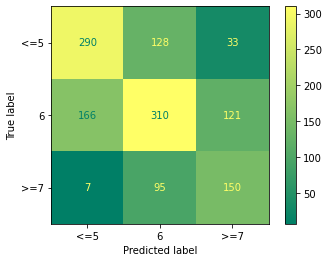

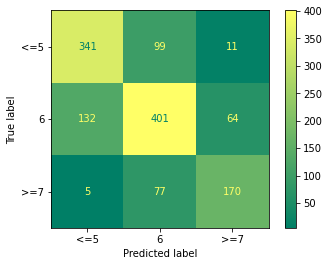

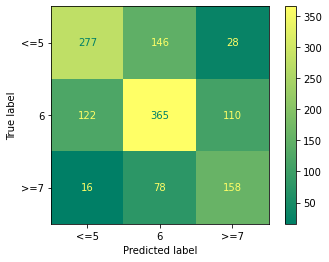

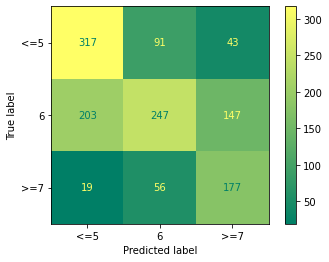

In [341]:
#creates intial confusion matrices for all 4 classifiers
plot_confusion_matrix(svm_model, test_X, test_Y, labels = ["<=5", "6", ">=7"], cmap = "summer")
plot_confusion_matrix(random_forest, test_X, test_Y, labels = ["<=5", "6", ">=7"], cmap = "summer") 
plot_confusion_matrix(knn, test_X, test_Y, labels = ["<=5", "6", ">=7"], cmap = "summer") 
plot_confusion_matrix(ada, test_X, test_Y, labels = ["<=5", "6", ">=7"], cmap = "summer") 

## Model K-fold evaluation

In [459]:
def k_fold_eval(classifier, svm=False):   
    
    #intiates kfold with 5 splits
    kf = KFold(n_splits=5, random_state = 42, shuffle =True)
    accuracy_test = []
    auc_test = []
    accuracy_train = []
    auc_train = []

    #goes through eahc split
    for train_index, test_index in kf.split(standard_X):
        cl = classifier
        
        #data is split into train and test and uesed Smote
        train_X, test_X = standard_X.iloc[train_index,:], standard_X.iloc[test_index,:]
        train_Y, test_Y = Y[train_index], Y[test_index]
        train_X_smote, train_Y_smote =sm.fit_resample(train_X, train_Y)
        
        #model is trained
        cl =cl.fit(train_X_smote, train_Y_smote)
        
        #accuracy is added for the fold
        accuracy_test.append(accuracy_score(test_Y, cl.predict(test_X)))
        accuracy_train.append(accuracy_score(train_Y, cl.predict(train_X)))
        
        #as svm proba is unreliable and inefficient it is skipped
        if svm:
            auc_test.append(None)
            auc_train.append(None)
        else:
        
            auc_test.append(roc_auc_score(test_Y, cl.predict_proba(test_X), multi_class='ovr'))
            auc_train.append(roc_auc_score(train_Y, cl.predict_proba(train_X), multi_class='ovr'))
        
        
    #returns a data frame of accuracies and AUC
    return(pd.DataFrame(data ={"test accuracy" : accuracy_test, "test AUC" :auc_test, "train accuracy": accuracy_train,
                               "train AUC": auc_train} ))

In [455]:
#runs Kfold on randomforest
randomForest = k_fold_eval(RandomForestClassifier(n_estimators = 100, max_features = 3, max_depth = 20, bootstrap = False, random_state = 42))

In [456]:
randomForest

,test accuracy,test AUC,train accuracy,train AUC
0,0.707692,0.880970,0.999808,1.0
1,0.713846,0.880279,1.000000,1.0
2,0.732871,0.894221,1.000000,1.0
3,0.728253,0.890025,1.000000,1.0
4,0.715935,0.890022,0.999808,1.0


In [457]:
#runs Kfold on KNN
knNeighbour = k_fold_eval(KNeighborsClassifier(n_neighbors = 4, metric = "manhattan"))
knNeighbour

,test accuracy,test AUC,train accuracy,train AUC
0,0.610000,0.777132,0.801616,0.940811
1,0.604615,0.782135,0.794497,0.940638
2,0.609700,0.774742,0.802424,0.942799
3,0.604311,0.783039,0.803771,0.943798
4,0.616628,0.788657,0.802232,0.941245


In [458]:
#runs Kfold on AdaBoost
adaBoost = k_fold_eval(AdaBoostClassifier(n_estimators =100, learning_rate= 0.8, random_state = 42))
adaBoost

,test accuracy,test AUC,train accuracy,train AUC
0,0.566923,0.709084,0.588801,0.733718
1,0.556923,0.712741,0.583991,0.734729
2,0.555812,0.716570,0.581955,0.731644
3,0.568129,0.709560,0.568873,0.729069
4,0.567360,0.702984,0.588880,0.733250


In [460]:
#runs Kfold on SVM
SVMmodel = k_fold_eval(SVC(kernel = "poly", probability = True, random_state = 42), svm =True)
SVMmodel 

,test accuracy,test AUC,train accuracy,train AUC
0,0.580000,None,0.636136,None
1,0.598462,None,0.625553,None
2,0.584296,None,0.627934,None
3,0.579677,None,0.624663,None
4,0.591994,None,0.628896,None


In [465]:
#Evaluation is colapped into one dataframe
pd.DataFrame(data = {"Random Forest mean":randomForest.mean(), "Random Forest s.d.":randomForest.std(),
                    "KNN mean":knNeighbour.mean(), "KNN s.d.":knNeighbour.std(),
                    "adaBoost mean":adaBoost.mean(), "adaBoost s.d.":adaBoost.std(),
                    "SVMmean":SVMmodel .mean(), "SVM s.d.":SVMmodel .std(),})

,Random Forest mean,Random Forest s.d.,KNN mean,KNN s.d.,adaBoost mean,adaBoost s.d.,SVMmean,SVM s.d.
test accuracy,0.719720,0.010479,0.609051,0.005022,0.563029,0.006109,0.586886,0.008158
test AUC,0.887103,0.006163,0.781141,0.005434,0.710188,0.005019,NaN,NaN
train accuracy,0.999923,0.000105,0.800908,0.003669,0.582500,0.008195,0.628636,0.004530
train AUC,1.000000,0.000000,0.941858,0.001379,0.732482,0.002209,NaN,NaN
